In [1]:
import cv2
import numpy as np
import os
from keras.utils import image_dataset_from_directory
import tensorflow as tf

2022-12-03 11:35:40.486665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 11:35:40.624608: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sweekar/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-03 11:35:40.624625: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-03 11:35:40.679212: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already

In [2]:
path = 'Resources/Datasets/Training'

In [3]:
path

'Resources/Datasets/Training'

In [4]:
myList = os.listdir(path)

In [5]:
print(myList)

['pituitary', 'notumor', 'glioma', 'meningioma']


In [6]:
batch_size = 32
img_height = 227
img_width = 227

In [7]:
train_ds = image_dataset_from_directory(
    path,
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


2022-12-03 11:35:42.448443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sweekar/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-03 11:35:42.448459: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-03 11:35:42.448490: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sweekar-Aspire-A514-51): /proc/driver/nvidia/version does not exist
2022-12-03 11:35:42.448699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
val_ds = image_dataset_from_directory(
    path,
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


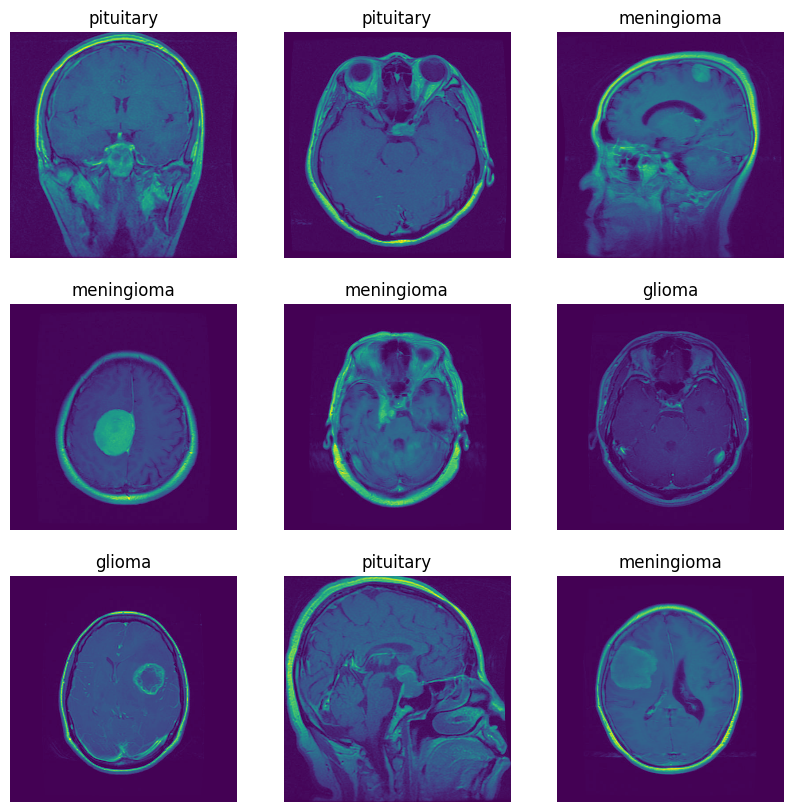

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 227, 227, 1)
(32,)


In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
from keras.utils.np_utils import to_categorical

In [15]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

class_names = np.array(class_names)

label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(class_names)

In [16]:
class_names = to_categorical(vec,4)

In [17]:
#Rescaling to 1./255
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

2022-12-03 11:35:44.831103: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation
from keras.layers import LayerNormalization,ZeroPadding2D

In [19]:
def nextModel():
    nmodel=Sequential()
    
    nmodel.add(Conv2D(filters=128,kernel_size=(6,6),strides=(4,4),input_shape=(227,227,1),padding="valid"))
    #Relu-1
    nmodel.add(Activation('relu'))
    nmodel.add(LayerNormalization())
    nmodel.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid"))
    nmodel.add(ZeroPadding2D(padding=(2,2)))
    
    nmodel.add(Conv2D(filters=96,kernel_size=(6,6),strides=(1,1),padding="valid"))
    #Relu-2
    nmodel.add(Activation('relu'))
    nmodel.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid"))
    nmodel.add(ZeroPadding2D(padding=(2,2)))
    
    nmodel.add(Conv2D(filters=96,kernel_size=(2,2),strides=(1,1),padding="valid"))
    #Relu-3
    nmodel.add(Activation('relu'))
    nmodel.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid"))
    nmodel.add(ZeroPadding2D(padding=(2,2)))
    
    nmodel.add(Conv2D(filters=24,kernel_size=(6,6),strides=(1,1),padding="valid"))
    #Relu-4
    nmodel.add(Activation('relu'))
    nmodel.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid"))
    nmodel.add(ZeroPadding2D(padding=(2,2)))
    
    nmodel.add(Conv2D(filters=24,kernel_size=(6,6),strides=(1,1),padding="valid"))
    #Relu-5
    nmodel.add(Activation('relu'))
    nmodel.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid"))
    nmodel.add(ZeroPadding2D(padding=(2,2)))
    
    nmodel.add(Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="valid"))
    #Relu-6
    nmodel.add(Activation('relu'))
    nmodel.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid"))   
    
    nmodel.add(Flatten())
    
    nmodel.add(Dense(512))
               
    nmodel.add(Dropout(0.3))
    nmodel.add(Dense(4))
    nmodel.add(Activation('softmax'))
    
    nmodel.compile(optimizer="nadam",loss="sparse_categorical_crossentropy",metrics=['accuracy'])
    
    return nmodel

In [20]:
newModel = nextModel()
print(newModel.output_shape)

(None, 4)


In [21]:
newModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 128)       4736      
                                                                 
 activation (Activation)     (None, 56, 56, 128)       0         
                                                                 
 layer_normalization (LayerN  (None, 56, 56, 128)      256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 128)      0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 32, 32, 128)      0         
 2D)                                                             
                                                        

In [22]:
batch_size_val = 32
epoch_val=20
steps_per_epoch_val=143

history = newModel.fit(train_ds,batch_size=batch_size_val,steps_per_epoch=steps_per_epoch_val,epochs=epoch_val,validation_data=val_ds)

Epoch 1/20
143/143 [==============================] - 177s 1s/step - loss: 1.0934 - accuracy: 0.5042 - val_loss: 0.8006 - val_accuracy: 0.7312
Epoch 2/20
143/143 [==============================] - 169s 1s/step - loss: 0.5235 - accuracy: 0.8217 - val_loss: 0.4645 - val_accuracy: 0.8406
Epoch 3/20
143/143 [==============================] - 169s 1s/step - loss: 0.3628 - accuracy: 0.8779 - val_loss: 0.4052 - val_accuracy: 0.8581
Epoch 4/20
143/143 [==============================] - 142s 991ms/step - loss: 0.2936 - accuracy: 0.8982 - val_loss: 0.3592 - val_accuracy: 0.8660
Epoch 5/20
143/143 [==============================] - 144s 1s/step - loss: 0.2527 - accuracy: 0.9107 - val_loss: 0.3106 - val_accuracy: 0.8905
Epoch 6/20
143/143 [==============================] - 144s 1s/step - loss: 0.2072 - accuracy: 0.9223 - val_loss: 0.3062 - val_accuracy: 0.9046
Epoch 7/20
143/143 [==============================] - 145s 1s/step - loss: 0.1791 - accuracy: 0.9315 - val_loss: 0.2882 - val_accuracy: 0.8

In [23]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Epoch')

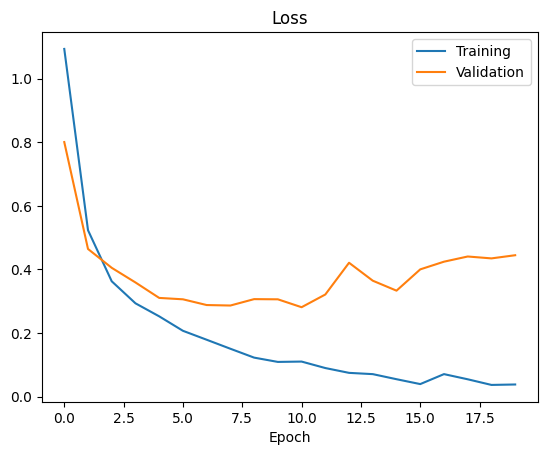

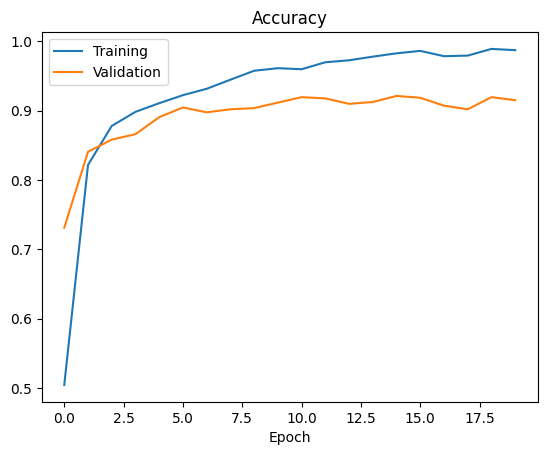

In [24]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training','Validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')

In [25]:
plt.show()

In [26]:
newModel.save('Resources/saved_Model')

INFO:tensorflow:Assets written to: Resources/saved_Model/assets


INFO:tensorflow:Assets written to: Resources/saved_Model/assets


In [27]:
test_ds = image_dataset_from_directory(
    'Resources/Datasets/Testing',
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 1311 files belonging to 4 classes.
Using 1049 files for training.


In [28]:
score = newModel.evaluate(test_ds,verbose=0)
print(f'Test Score = {score[0]}\nTest Accuracy = {score[1]}')

Test Score = 0.29852917790412903
Test Accuracy = 0.9218302965164185
